# Dubrow and Divachi 2013
**TODO**: Describe experiment and the implementation of the simulations

**TODO**: Clean up this simluations and re-run simluations for inteligability

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from models import SEM, KerasSimpleRNN

np.random.seed(1234)
sns.set_context('paper', font_scale=1.5)

Using TensorFlow backend.


In [2]:
# N = 30  # 6 events of five objects each
from sklearn.preprocessing import normalize

event_duration = 5
n_events = 5
N = event_duration  * n_events
D = 25

def generate_experiment(seed=None, scaling_factor=1.0):
    if seed:
        np.random.seed(seed)
    
    X = np.random.randn(N, D)

    # embed a similarity structure within the items of each category
    # by adding the same random vector to all of the items within the
    # category
    categ_one = np.random.randn(1, D) * scaling_factor
    categ_two = np.random.randn(1, D) * scaling_factor
    
    for ii in range(n_events):
        if ii % 2 == 0:
            X[ii*event_duration:ii*event_duration +event_duration, :] += categ_one
        else:
            X[ii*event_duration:ii*event_duration +event_duration, :] += categ_two

    return normalize(X)

pre_locs = np.array([ii*event_duration+event_duration for ii in range(n_events-1)])
pst_locs = np.array([ii*event_duration+event_duration-1 for ii in range(n_events-1)])

Set the parameters for the event models

In [3]:
# for our purposes, we need to properly encode the transition function accurately
f_opts=dict( n_epochs=100, optimizer='adam', n_hidden1=D, n_hidden2=D,
    l2_regularization=0.0, dropout=0.00)

In [4]:
X = generate_experiment()

def train_single_event(X):
    event_model = KerasSimpleRNN(D, **f_opts)
    event_model.update_f0(X[0, :])
    for ii in range(1, np.shape(X)[0]):
        event_model.update(X[ii-1, :], X[ii, :])
    return event_model

event_model = train_single_event(X)
print "Event Model Error", np.sum((X - event_model.run_generative(N))**2)

# for comparison, the generative error of an untrained model
null_model = KerasSimpleRNN(D, **f_opts)
print "Null  Model Error", np.sum((X - null_model.run_generative(N))**2)

Event Model Error 6.964179888051253
Null  Model Error 25.0


In [5]:
# noise parameter
tau = 1.00
X_mem = X + np.random.randn(N, D) * tau

# Reconstruction
Define the two sampling functions used in the reconstruction memory process. One, were all of these scenes are a part of one big event, the other where all are a part of multiple events with unknown type

In [6]:
from tqdm import tnrange

def reconstruction_single_event(X_mem, event_model, tau=1.0, beta=0.01, burn_in=500, 
                                n_samples=5000):
    
    #these are shuffeled in order
    trials = range(0, N)
    X_sample = []
    
    # randomly initialize the sampel of X0 from the corruption process
    X0 = np.random.randn(N, D) * tau + X_mem
    
    # because the beta and tau are assumed and constant, we can pre-cacluate u 
    # and lambda for the weighted mean of the posterior over x
    u = (1./beta) / (1./beta + 1./tau)
    lmda = 1.0 / (1./beta + 1./tau)
    
    for ii in tnrange(n_samples + burn_in, leave=False, desc='Gibbs'):
        
        np.random.shuffle(trials) # randomize the order trials are sampled

        for t in trials:
            # pull the transition function
            if t > 1:
                def f(x):
                    return event_model.predict_next_generative(x)
            else:
                def f(x):
                    return event_model.predict_f0()

            # construct the input vector for the model
            X_i = X0[:t, :]

            # use the likelihood function to estimate a new sample. 
            # This likelihood function is the product of two gaussians:
            #  N(x0_t; f(x0_{1:t-1}), beta_f * I) * N(x0_t; \tilde x_t , beta_mem * I )
            mu_t = u * f(X_i) + (1 - u) * X_mem[t]

            # generate a sample from the multivariate normal
            X0[t, :] = np.random.multivariate_normal(mu_t.flatten(), lmda * np.eye(D))

        if ii >= burn_in:
            X_sample.append(X0.copy())
            
    return np.array(X_sample)

In [7]:
from scipy.stats import multivariate_normal as mvnorm
from scipy.special import logsumexp


def reconstruction_known_boundaries(X_mem, events_dict, event_tokens,
                                    tau=1.0, beta=0.01, burn_in=500, n_samples=5000):
    
    #these are shuffeled in order, and we don't want to make a prediction for the last scene
    trials = range(0, N)
    X_sample = []
    
    # randomly initialize the sampel of X0 from the corruption process
    X0 = np.random.randn(N, D) * tau + X_mem
    
    # randomly initialize the identity of the event tokens
    events_keys_function = np.random.permutation(events_dict.keys())
    
    # because the beta and tau are assumed and constant, we can pre-cacluate u 
    # and lambda for the weighted mean of the posterior over x
    u = (1./beta) / (1./beta + 1./tau)
    lmda = 1.0 / (1./beta + 1./tau)
    
    for ii in tnrange(n_samples + burn_in, leave=False, desc='Gibbs'):
        
        np.random.shuffle(trials) # randomize the order trials are sampled

        for t in trials:

            # pull the transition function associated with the current event-token
            token = event_tokens[t]
            token_id = events_keys_function[token]
            if token == event_tokens[t-1]:
                def f(x):
                    return events_dict[token_id].predict_next_generative(x)
            else:
                def f(x):
                    return events_dict[token_id].predict_f0()
                
            # construct the input vector for the model
            X_i = X0[(np.arange(N) < t) & (np.array(event_tokens) == event_tokens[t]), :]

            # use the likelihood function to estimate a new sample. 
            # This likelihood function is the product of two gaussians:
            #  N(x0_t; f(x0_{1:t-1}), beta_f * I) * N(x0_t; \tilde x_t , beta_mem * I )
            mu_t = u * f(X_i) + (1 - u) * X_mem[t]

            # generate a sample from the multivariate normal
            X0[t, :] = np.random.multivariate_normal(mu_t.flatten(), lmda * np.eye(D))
            
            
        # Here, we sample the events type probability, conditioned on the samples
        
        # we will sample the event models WITHOUT replacement, so keep track 
        # of the available models (this also speeds things up)
        available_models = events_dict.keys()
        
        events_keys_function = np.zeros(len(available_models)) - 1  # reinitialize the key
        
        for token0 in np.random.permutation(list(set(events_token))):
            # get the likelihood for each token in the set
            X00 = X0[events_token == token0, :]  # pull the relevant scenes
            
            # initialze the scores. This includes models that are not avialble,
            # so they have to be initialized at log p(e) = -infty (or np.log(0))
            scores = np.log(np.zeros(np.max(available_models) + 1))
            
            # loop throught the as yet unassigned models and "score" (log likelihood)
            for token_id0 in available_models:
                # pull the coresponding event model
                e00 = events_dict[token_id0]
                
                # run the model to generate predictions
                X00_hat = np.zeros(np.shape(X00))
                X00_hat[0, :] = e00.predict_f0()
                for jj in range(1, np.shape(X00)[0]):
                    X00_hat[jj, :] = e00.predict_next_generative(X00[:jj, :])
                    
                # evaluate the predictions of the model
                scores[token_id0] = logsumexp(
                    mvnorm.logpdf(X00 - X00_hat, mean=np.zeros(D), cov=np.eye(D) * beta)
                )
            
            # normalize the loglikelihoods and inverse cdf sample
            pmf_e = np.exp(scores - logsumexp(scores))
            cmf_e = np.cumsum(pmf_e)
            e0 =  events_dict.keys()[np.sum(cmf_e < np.random.rand())]
            
            events_keys_function[token0] = e0
            try:
                available_models.remove(e0)        
            except:
                print available_models
                print e0
                print pmf_e
                print scores
                raise(Exception)
                
        if ii >= burn_in:
            X_sample.append(X0.copy())
            
    return np.array(X_sample)

In [8]:
def reconstruction_known_events(X_mem, events_dict, event_tokens,
                                tau=1.0, beta=0.01, burn_in=500, n_samples=5000):
    
    #these are shuffeled in order, and we don't want to make a prediction for the last scene
    trials = range(0, N)
    X_sample = []
    
    # randomly initialize the sampel of X0 from the corruption process
    X0 = np.random.randn(N, D) * tau + X_mem
    
    # randomly initialize the identity of the event tokens
    events_keys_function = np.random.permutation(events_dict.keys())
    
    # because the beta and tau are assumed and constant, we can pre-cacluate u 
    # and lambda for the weighted mean of the posterior over x
    u = (1./beta) / (1./beta + 1./tau)
    lmda = 1.0 / (1./beta + 1./tau)
    
    for ii in tnrange(n_samples + burn_in, leave=False, desc='Gibbs'):
        
        np.random.shuffle(trials) # randomize the order trials are sampled

        for t in trials:

            # pull the transition function associated with the current event-token
            token = event_tokens[t]
            if token == event_tokens[t-1]:
                def f(x):
                    return events_dict[token].predict_next_generative(x)
            else:
                def f(x):
                    return events_dict[token].predict_f0()
                
            # construct the input vector for the model
            X_i = X0[(np.arange(N) < t) & (np.array(event_tokens) == event_tokens[t]), :]

            # use the likelihood function to estimate a new sample. 
            # This likelihood function is the product of two gaussians:
            #  N(x0_t; f(x0_{1:t-1}), beta_f * I) * N(x0_t; \tilde x_t , beta_mem * I )
            mu_t = u * f(X_i) + (1 - u) * X_mem[t]

            # generate a sample from the multivariate normal
            X0[t, :] = np.random.multivariate_normal(mu_t.flatten(), lmda * np.eye(D))
                
        if ii >= burn_in:
            X_sample.append(X0.copy())
            
    return np.array(X_sample)


In [9]:
event_model = train_single_event(X)
X_sample = reconstruction_single_event(X_mem, event_model)
print X_sample.shape

HBox(children=(IntProgress(value=0, description=u'Gibbs', max=5500), HTML(value=u'')))

(5000, 25, 25)


In [10]:
def segment_scenes(event_tokens):
    # we assume the segemenation is done correctly
    events_dict = dict()
    for t0 in set(event_tokens):
        events_dict[t0] = train_single_event(X[t0 == np.array(event_tokens), :])
    return events_dict

# we assume the event boundary locations are known. This code seperates all of the 
# events with unique tokens (which, in this case, is also their type. This information
# isn't given to the model)
events_token = [0] * 5 + [1] * 5 + [2] * 5 + [3] * 5 + [4] * 5

events_dict = segment_scenes(events_token)

In [11]:
X_sample_uknbound = reconstruction_known_boundaries(X_mem, events_dict, events_token)

HBox(children=(IntProgress(value=0, description=u'Gibbs', max=5500), HTML(value=u'')))

/anaconda2/envs/sem/lib/python2.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: divide by zero encountered in log


In [12]:
X_sample_knownevent = reconstruction_known_events(X_mem, events_dict, events_token)

HBox(children=(IntProgress(value=0, description=u'Gibbs', max=5500), HTML(value=u'')))

In [13]:
print "Event  Model Error", np.sum((X[5:10, :] - events_dict[1].run_generative(5))**2)

# for comparison, the generative error of an untrained model
null_model = KerasSimpleRNN(D, **f_opts)
print "Null  Model Error", np.sum((X[5:10, :] - null_model.run_generative(5))**2)

Event  Model Error 0.010940745214931864
Null  Model Error 5.0


In [14]:
print "Event  Model Error", np.sum((X[:5, :] - events_dict[0].run_generative(5))**2)

# for comparison, the generative error of an untrained model
null_model = KerasSimpleRNN(D, **f_opts)
print "Null  Model Error", np.sum((X[:5, :] - null_model.run_generative(5))**2)

Event  Model Error 0.046551498913429995
Null  Model Error 5.000000000000001


# Evaluate the reconstruction
Try to get a sense of the error of the reconstructed memory predictions for one or multiple events

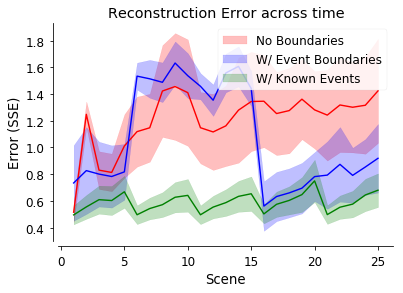

In [15]:
fig, ax = plt.subplots()

sse = np.linalg.norm(X_sample - np.tile(X, (5000, 1, 1)), axis=2)
y = np.mean(sse, axis=0)
y_err = np.std(sse, axis=0)
ax.plot(range(1, 26), y, 'r')
ax.fill_between(range(1, 26), y+y_err, y-y_err, color='r', alpha=0.25, label='No Boundaries')

sse = np.linalg.norm(X_sample_uknbound - np.tile(X, (5000, 1, 1)), axis=2)
y = np.mean(sse, axis=0)
y_err = np.std(sse, axis=0)
ax.plot(range(1, 26), y, 'b')
ax.fill_between(range(1, 26), y+y_err, y-y_err, color='b', alpha=0.25, label='W/ Event Boundaries')

sse = np.linalg.norm(X_sample_knownevent - np.tile(X, (5000, 1, 1)), axis=2)
y = np.mean(sse, axis=0)
y_err = np.std(sse, axis=0)
ax.plot(range(1, 26), y, 'g')
ax.fill_between(range(1, 26), y+y_err, y-y_err, color='g', alpha=0.25, label='W/ Known Events')

plt.legend()
plt.ylabel('Error (SSE)')
plt.xlabel('Scene')
plt.title('Reconstruction Error across time')
sns.despine(offset=5)
plt.savefig('Divachi_reconstruction_sse.png', dpi=300, bbox_inches='tight')

Repeate the above, but this time evaluate each point without respect to time

In [16]:
def sse_no_time(sample):
    y = []
    y_err = []
    for ii in range(0, N):
        sse = np.linalg.norm(sample.reshape(-1, D) - X[ii, :].reshape(-1, D), axis=1)
        y.append(sse.mean())
        y_err.append(sse.std())
    return np.array(y), np.array(y_err)
    

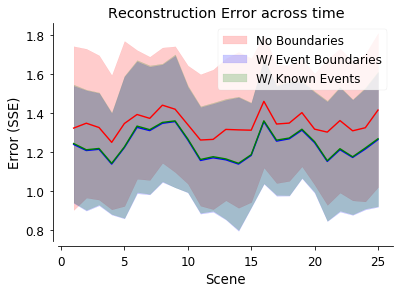

In [17]:
fig, ax = plt.subplots()

# sse = np.linalg.norm(X_sample.reshapeape(-1, D) - X, axis=2)
y, y_err = sse_no_time(X_sample)
ax.plot(range(1, 26), y, 'r')
ax.fill_between(range(1, 26), y+y_err, y-y_err, color='r', alpha=0.2, label='No Boundaries')

y, y_err = sse_no_time(X_sample_uknbound)
ax.plot(range(1, 26), y, 'b')
ax.fill_between(range(1, 26), y+y_err, y-y_err, color='b', alpha=0.2, label='W/ Event Boundaries')

y, y_err = sse_no_time(X_sample_knownevent)
ax.plot(range(1, 26), y, 'g')
ax.fill_between(range(1, 26), y+y_err, y-y_err, color='g', alpha=0.2, label='W/ Known Events')

plt.legend()
plt.ylabel('Error (SSE)')
plt.xlabel('Scene')
plt.title('Reconstruction Error')
sns.despine(offset=5)

okay great! as in the pettijohn simluations, the presense of event boundaries reduces the overall reconstruction error

# Okay! Now we can look at memory stuff

In [21]:
from sklearn.neighbors import KernelDensity

def make_joint_density(X_sample, h=0.2):
    # map the sample to sequential pairs (X_t-1, X_t) --> Y_t
    Y_sample = np.concatenate([X_sample[:, 1:, :], X_sample[:, :-1, :]], axis=2
                             ).reshape(-1, D*2)

    kde = KernelDensity(kernel='gaussian', bandwidth=h).fit(Y_sample)
    return kde

def make_marginal_density(X_sample, h=0.2):
    kde = KernelDensity(kernel='gaussian', bandwidth=h).fit(X_sample[:, 1:, :].reshape(-1, D))
    return kde

First, plot the joint distribution of items $\mathbf{x}_{i}$ and $\mathbf{x}_{i-1}$ as from t=1 (zero indexing) to N

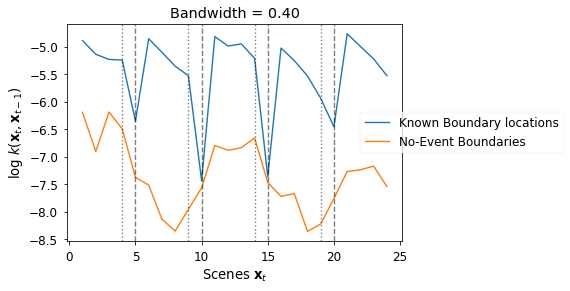

In [22]:
pre_boundary_scenes = [4, 9, 14, 19]
post_boundary_scenes = [5, 10, 15, 20]

Y = np.concatenate([X[1:, :], X[:-1, :]], axis=1)


h=0.4

k_joint = make_joint_density(X_sample_uknbound, h=h)
marginals_mult = [k_joint.score_samples(Y[ii, :].reshape(1, -1)) for ii in range(0, N-1)]
plt.plot(range(1, N), marginals_mult, label='Known Boundary locations')

# k_joint = make_joint_density(X_sample_knownevent, h=0.4)
# marginals_mult = [k_joint.score_samples(Y[ii, :].reshape(1, -1)) for ii in range(0, N-1)]
# plt.plot(range(1, N), marginals_mult, label='Known Events')

k_joint = make_joint_density(X_sample, h=h)
marginals_sing = [k_joint.score_samples(Y[ii, :].reshape(1, -1)) for ii in range(0, N-1)]
plt.plot(range(1, N), marginals_sing, label='No-Event Boundaries')
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))

ax = plt.gca()
ylb, yub = ax.get_ylim()
for b in pre_boundary_scenes:
    plt.plot([b, b], [ylb, yub], 'k:', alpha=0.5)

for b in post_boundary_scenes:
    plt.plot([b, b], [ylb, yub], 'k--', alpha=0.5)
    
ax.set_ylim(ylb, yub)

ax.set_ylabel(r'log $k(\mathbf{x}_{t}, \mathbf{x}_{t-1})$')
ax.set_xlabel(r'Scenes $\mathbf{x}_t$')
ax.set_title('Bandwidth = %.2f' % h)
plt.savefig('Divachi_joint_distribution.png', dpi=300, bbox_inches='tight')

Next, plot the conditional distribution of items $\mathbf{x}_{i-1}|\mathbf{x}_{i}$ and  as from t=1 (zero indexing) to N

Text(0.5,1,u'Bandwidth = 0.40')

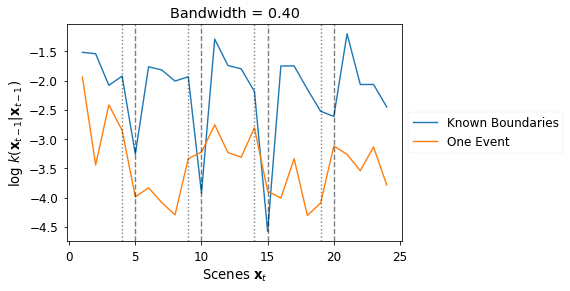

In [23]:
pre_boundary_scenes = [4, 9, 14, 19]
post_boundary_scenes = [5, 10, 15, 20]

h = 0.4

k_joint = make_joint_density(X_sample_uknbound, h=h)
k_margi = make_marginal_density(X_sample_uknbound, h=h)
marginals_mult = [k_joint.score_samples(Y[ii, :].reshape(1, -1)) 
                  - k_margi.score_samples(X[ii-1, :].reshape(1, -1))
                  for ii in range(0, N-1)]
plt.plot(range(1, N), marginals_mult, label='Known Boundaries')


k_joint = make_joint_density(X_sample, h=h)
k_margi = make_marginal_density(X_sample, h=h)
marginals_sing = [k_joint.score_samples(Y[ii, :].reshape(1, -1)) 
                  - k_margi.score_samples(X[ii-1, :].reshape(1, -1))
                  for ii in range(0, N-1)]
plt.plot(range(1, N), marginals_sing, label='One Event')
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))

ax = plt.gca()
ylb, yub = ax.get_ylim()
for b in pre_boundary_scenes:
    plt.plot([b, b], [ylb, yub], 'k:', alpha=0.5)

for b in post_boundary_scenes:
    plt.plot([b, b], [ylb, yub], 'k--', alpha=0.5)
    
ax.set_ylim(ylb, yub)

ax.set_ylabel(r'log $k(\mathbf{x}_{t-1}|\mathbf{x}_{t-1})$')
ax.set_xlabel(r'Scenes $\mathbf{x}_t$')
ax.set_title('Bandwidth = %.2f' % h)

## Joint Density as a function of Bandwidth

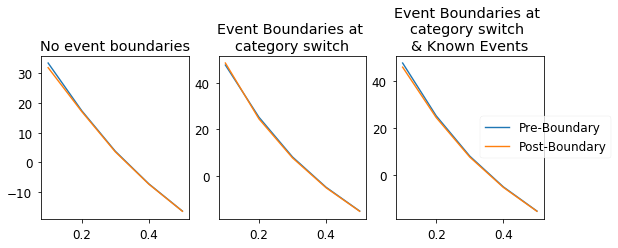

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3))

hs = np.arange(0.1, 0.51, 0.1)

# create the map to Y

def score_joint(sample, hs):
    
    score_pre = [None] * len(hs)
    score_pst = [None] * len(hs)
    
    for jj, h in enumerate(hs):
        # note! Y is a function from 1:N whereas everything else is a function of 0:N
        # this is b/c Y_t is a concanation of x_t & x_{t-1}, which is undefined for t = 0

        k_joint = make_joint_density(np.array(sample), h=h)

        score_pre0 = [k_joint.score_samples(Y[ii + 1, :].reshape(1, -1)) for ii in pre_boundary_scenes]
        score_pre[jj] = logsumexp(score_pre0) - np.log(len(score_pre0))

        score_pst0 = [k_joint.score_samples(Y[ii + 1, :].reshape(1, -1)) for ii in post_boundary_scenes]
        score_pst[jj] = logsumexp(score_pst0) - np.log(len(score_pst0))

    return score_pre, score_pst

#### one big event! ##

ax = axes[0]

score_pre, score_pst = score_joint(X_sample, hs)
    
ax.plot(hs, score_pre, label='Pre-Boundary')
ax.plot(hs, score_pst, label='Post-Boundary')
ax.set_title('No event boundaries')

#### with event boundaries! ##

ax = axes[1]

score_pre, score_pst = score_joint(X_sample_uknbound, hs)

ax.plot(hs, score_pre, label='Pre-Boundary')
ax.plot(hs, score_pst, label='Post-Boundary')
ax.set_title('Event Boundaries at \ncategory switch')


ax = axes[2]

score_pre, score_pst = score_joint(X_sample_knownevent, hs)
    
ax.plot(hs, score_pre, label='Pre-Boundary')
ax.plot(hs, score_pst, label='Post-Boundary')
ax.set_title('Event Boundaries at \ncategory switch \n& Known Events')

plt.legend(bbox_to_anchor=(1.5, 0.5), loc='center right')

# Conditional Density as a function of Bandwidth

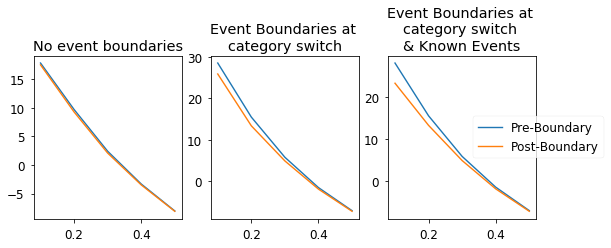

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3))

hs = np.arange(0.1, 0.51, 0.1)

# create the map to Y
Y = np.concatenate([X[1:, :], X[:-1, :]], axis=1)

def score_marg(sample, hs):
    
    score_pre = [None] * len(hs)
    score_pst = [None] * len(hs)
    
    for jj, h in enumerate(hs):
        # note! Y is a function from 1:N whereas everything else is a function of 0:N
        # this is b/c Y_t is a concanation of x_t & x_{t-1}, which is undefined for t = 0

        k_joint = make_joint_density(np.array(sample), h=h)
        k_margi = make_marginal_density(sample, h=h)

        score_pre0 = [k_joint.score_samples(Y[ii + 1, :].reshape(1, -1)) 
                      - k_margi.score_samples(X[ii, ].reshape(1, -1))
                      for ii in pre_boundary_scenes]
        score_pre[jj] = logsumexp(score_pre0) - np.log(len(score_pre0))

        score_pst0 = [
            k_joint.score_samples(Y[ii + 1, :].reshape(1, -1)) 
            - k_margi.score_samples(X[ii, ].reshape(1, -1))
            for ii in post_boundary_scenes]
        score_pst[jj] = logsumexp(score_pst0) - np.log(len(score_pst0))

    return score_pre, score_pst

#### one big event! ##
ax = axes[0]
score_pre, score_pst = score_marg(X_sample, hs)
ax.plot(hs, score_pre, label='Pre-Boundary')
ax.plot(hs, score_pst, label='Post-Boundary')
ax.set_title('No event boundaries')

#### with event boundaries! ##
ax = axes[1]
score_pre, score_pst = score_marg(X_sample_uknbound, hs)
ax.plot(hs, score_pre, label='Pre-Boundary')
ax.plot(hs, score_pst, label='Post-Boundary')
ax.set_title('Event Boundaries at \ncategory switch')

#### with event boundaries! ##
ax = axes[2]
score_pre, score_pst = score_marg(X_sample_knownevent, hs)
ax.plot(hs, score_pre, label='Pre-Boundary')
ax.plot(hs, score_pst, label='Post-Boundary')
ax.set_title('Event Boundaries at \ncategory switch \n& Known Events')

plt.legend(bbox_to_anchor=(1.5, 0.5), loc='center right')

# Okay!!! Now batch the thing

In [27]:
def batch(n_samples=500, hs=None):
    if hs is None:
        hs = np.arange(0.1, 0.51, 0.1)
    
    X = generate_experiment()

    event_model = train_single_event(X)
    X_sample = reconstruction_single_event(X_mem, event_model, n_samples=n_samples)
    
    events_token = [0] * 5 + [1] * 5 + [2] * 5 + [3] * 5 + [4] * 5

    events_dict = segment_scenes(events_token)
    
    X_sample_uknbound = reconstruction_known_boundaries(X_mem, events_dict, events_token, n_samples=n_samples)
    
    # create the map to Y
    Y = np.concatenate([X[1:, :], X[:-1, :]], axis=1)

    def score_joint(sample, hs):

        score_pre = [None] * len(hs)
        score_pst = [None] * len(hs)

        for jj, h in enumerate(hs):
            # note! Y is a function from 1:N whereas everything else is a function of 0:N
            # this is b/c Y_t is a concanation of x_t & x_{t-1}, which is undefined for t = 0

            k_joint = make_joint_density(np.array(sample), h=h)

            score_pre0 = [k_joint.score_samples(Y[ii + 1, :].reshape(1, -1)) for ii in pre_boundary_scenes]
            score_pre[jj] = logsumexp(score_pre0) - np.log(len(score_pre0))

            score_pst0 = [k_joint.score_samples(Y[ii + 1, :].reshape(1, -1)) for ii in post_boundary_scenes]
            score_pst[jj] = logsumexp(score_pst0) - np.log(len(score_pst0))

        return score_pre, score_pst
    
    def score_marg(sample, hs):
    
        score_pre = [None] * len(hs)
        score_pst = [None] * len(hs)

        for jj, h in enumerate(hs):
            # note! Y is a function from 1:N whereas everything else is a function of 0:N
            # this is b/c Y_t is a concanation of x_t & x_{t-1}, which is undefined for t = 0

            k_joint = make_joint_density(np.array(sample), h=h)
            k_margi = make_marginal_density(sample, h=h)

            score_pre0 = [k_joint.score_samples(Y[ii + 1, :].reshape(1, -1)) 
                          - k_margi.score_samples(X[ii, ].reshape(1, -1))
                          for ii in pre_boundary_scenes]
            score_pre[jj] = logsumexp(score_pre0) - np.log(len(score_pre0))

            score_pst0 = [
                k_joint.score_samples(Y[ii + 1, :].reshape(1, -1)) 
                - k_margi.score_samples(X[ii, ].reshape(1, -1))
                for ii in post_boundary_scenes]
            score_pst[jj] = logsumexp(score_pst0) - np.log(len(score_pst0))

        return score_pre, score_pst
        
    joint_density = {
        'No-Boundaries': score_joint(X_sample, hs),
        'Known-Boundaries': score_joint(X_sample_uknbound, hs),
    }
    marg_density = {
        'No-Boundaries': score_marg(X_sample, hs),
        'Known-Boundaries': score_marg(X_sample_uknbound, hs),
    }
    
    return joint_density, marg_density

In [28]:
n_batches = 25
n_samples = 5000
hs = np.arange(0.1, 0.5, 0.05)

joint_no_bound_pre = np.zeros((n_batches, len(hs))) - np.inf
joint_no_bound_pst = np.zeros((n_batches, len(hs))) - np.inf 
joint_known_bound_pre = np.zeros((n_batches, len(hs))) - np.inf
joint_known_bound_pst = np.zeros((n_batches, len(hs))) - np.inf

marg_no_bound_pre = np.zeros((n_batches, len(hs))) - np.inf
marg_no_bound_pst = np.zeros((n_batches, len(hs))) - np.inf
marg_known_bound_pre = np.zeros((n_batches, len(hs))) - np.inf
marg_known_bound_pst = np.zeros((n_batches, len(hs))) - np.inf

for ii in tnrange(n_batches):
    joint_density, marg_density = batch(n_samples, hs=hs)
    
    joint_no_bound_pre[ii, :] = joint_density['No-Boundaries'][0]
    joint_no_bound_pst[ii, :] = joint_density['No-Boundaries'][1]
    joint_known_bound_pre[ii, :] = joint_density['Known-Boundaries'][0]
    joint_known_bound_pst[ii, :] = joint_density['Known-Boundaries'][1]
    marg_no_bound_pre[ii, :] = marg_density['No-Boundaries'][0]
    marg_no_bound_pst[ii, :] = marg_density['No-Boundaries'][1]
    marg_known_bound_pre[ii, :] = marg_density['Known-Boundaries'][0]
    marg_known_bound_pst[ii, :] = marg_density['Known-Boundaries'][1]

HBox(children=(IntProgress(value=0, max=25), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Gibbs', max=5500), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Gibbs', max=5500), HTML(value=u'')))

/anaconda2/envs/sem/lib/python2.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: divide by zero encountered in log


HBox(children=(IntProgress(value=0, description=u'Gibbs', max=5500), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Gibbs', max=5500), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Gibbs', max=5500), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Gibbs', max=5500), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Gibbs', max=5500), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Gibbs', max=5500), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Gibbs', max=5500), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Gibbs', max=5500), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Gibbs', max=5500), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Gibbs', max=5500), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Gibbs', max=5500), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Gibbs', max=5500), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Gibbs', max=5500), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Gibbs', max=5500), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Gibbs', max=5500), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Gibbs', max=5500), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Gibbs', max=5500), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Gibbs', max=5500), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Gibbs', max=5500), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Gibbs', max=5500), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Gibbs', max=5500), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Gibbs', max=5500), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Gibbs', max=5500), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Gibbs', max=5500), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Gibbs', max=5500), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Gibbs', max=5500), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Gibbs', max=5500), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Gibbs', max=5500), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Gibbs', max=5500), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Gibbs', max=5500), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Gibbs', max=5500), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Gibbs', max=5500), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Gibbs', max=5500), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Gibbs', max=5500), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Gibbs', max=5500), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Gibbs', max=5500), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Gibbs', max=5500), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Gibbs', max=5500), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Gibbs', max=5500), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Gibbs', max=5500), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Gibbs', max=5500), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Gibbs', max=5500), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Gibbs', max=5500), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Gibbs', max=5500), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Gibbs', max=5500), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Gibbs', max=5500), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Gibbs', max=5500), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Gibbs', max=5500), HTML(value=u'')))

# Marginal Density comparisons

## This is a direct comparison of the No Switch vs Switch via log Likelihood ratio

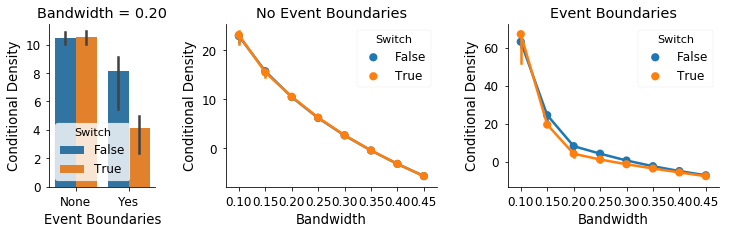

In [187]:
fig, axes = plt.subplots(1, 3, gridspec_kw={'width_ratios':[1, 2, 2], 'wspace':0.4}, figsize=(12, 3))

h = 0.2
sns.set_palette('tab10')

def log_mean(x):
    return logsumexp(x, axis=0) - np.log(np.shape(x)[0])

df = pd.concat([
    pd.DataFrame({
        'Event Boundaries': ["None"] * n_batches,
        'Switch': [False] * n_batches,
        'Score': marg_no_bound_pre[:, idx],
    }), pd.DataFrame({
        'Event Boundaries': ["None"] * n_batches,
        'Switch': [True] * n_batches,
        'Score': marg_no_bound_pst[:, idx]
    }), pd.DataFrame({
        'Event Boundaries': ["Yes"] * n_batches,
        'Switch': [False] * n_batches,
        'Score': marg_known_bound_pre[:, idx]
    }), pd.DataFrame({
        'Event Boundaries': ['Yes'] * n_batches,
        'Switch': [True] * n_batches,
        'Score': marg_known_bound_pst[:, idx]
    })
    
])


sns.barplot(data=df, x='Event Boundaries', y='Score', hue='Switch', estimator=log_mean, ax=axes[0])
axes[0].set_ylabel(r'Conditional Density')
axes[0].set_title('Bandwidth = %0.2f' % h)


df = []
for ii, h in enumerate(hs):
    df.append(pd.DataFrame({
        'Switch': [False] * n_batches,
        'Bandwidth': [h] * n_batches,
        'Conditional Density': marg_no_bound_pre[:, ii]
    }))
    df.append(pd.DataFrame({
        'Switch': [True] * n_batches,
        'Bandwidth': [h] * n_batches,
        'Conditional Density': marg_no_bound_pst[:, ii]
    }))
df = pd.concat(df)

sns.pointplot(x='Bandwidth', y='Conditional Density', hue='Switch', 
                   estimator=log_mean, data=df, ax = axes[1])

df = []
for ii, h in enumerate(hs):
    df.append(pd.DataFrame({
        'Switch': [False] * n_batches,
        'Bandwidth': [h] * n_batches,
        'Conditional Density': marg_known_bound_pre[:, ii]
    }))
    df.append(pd.DataFrame({
        'Switch': [True] * n_batches,
        'Bandwidth': [h] * n_batches,
        'Conditional Density': marg_known_bound_pst[:, ii]
    }))
df = pd.concat(df)

sns.pointplot(x='Bandwidth', y='Conditional Density', hue='Switch', 
                   estimator=log_mean, data=df, ax = axes[2])
axes[1].set_xticklabels(['%.2f' % h for h in hs])
axes[2].set_xticklabels(['%.2f' % h for h in hs])

axes[1].set_title('No Event Boundaries')
axes[2].set_title('Event Boundaries')

sns.despine()
plt.savefig('Divachi_ConditionalDensity.png', dpi=300, bbox_inches='tight')

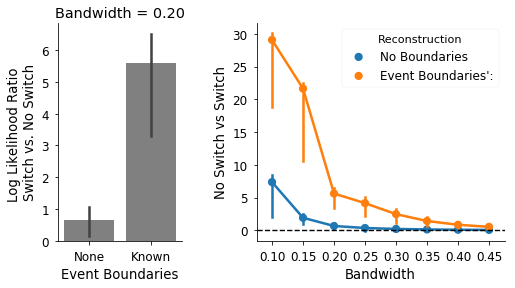

In [164]:
fig, axes = plt.subplots(1, 2, gridspec_kw={'width_ratios':[1, 2], 'wspace':0.4}, figsize=(8, 4))

h = 0.2

df = pd.concat([
    pd.DataFrame({
        'Event Boundaries': ["None"] * n_batches,
        'Score': marg_no_bound_pre[:, idx] - marg_no_bound_pst[:, idx],
    }), pd.DataFrame({
        'Event Boundaries': ["Known"] * n_batches,
        'Score': marg_known_bound_pre[:, idx] - marg_known_bound_pst[:, idx],
    })
])

def log_mean(x):
    return logsumexp(x, axis=0) - np.log(np.shape(x)[0])

sns.barplot(data=df, x='Event Boundaries', y='Score', 
            estimator=log_mean, color=[0.5, 0.5, 0.5], ax=axes[0])
axes[0].set_ylabel(u'Log Likelihood Ratio \nSwitch vs. No Switch')
axes[0].set_title('Bandwidth = %0.2f' % h)


df = []
for ii, h in enumerate(hs):
    df.append(pd.DataFrame({
        'Reconstruction': ["No Boundaries"] * n_batches,
        'Bandwidth': [h] * n_batches,
        'No Switch vs Switch': marg_no_bound_pre[:, ii] - marg_no_bound_pst[:, ii],
    }))
    df.append(pd.DataFrame({
        'Reconstruction': ["Event Boundaries':"] * n_batches,
        'Bandwidth': [h] * n_batches,
        'No Switch vs Switch':marg_known_bound_pre[:, ii] - marg_known_bound_pst[:, ii]
    }))
df = pd.concat(df)

sns.pointplot(x='Bandwidth', y='No Switch vs Switch', hue='Reconstruction', 
                   estimator=log_mean, data=df, ax = axes[1])
axes[1].plot(axes[1].get_xlim(), [0, 0], 'k--')
axes[1].set_xticklabels(['%.2f' % h for h in hs])

sns.despine()

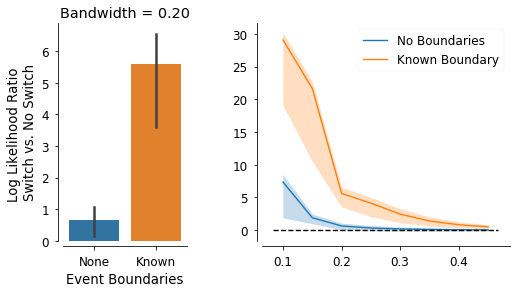

In [189]:
fig, axes = plt.subplots(1, 2, gridspec_kw={'width_ratios':[1, 2], 'wspace':0.4}, figsize=(8, 4))

h = 0.2

cc = sns.color_palette('tab10')
# sns.set_palette('viridis')


df = pd.concat([
    pd.DataFrame({
        'Event Boundaries': ["None"] * n_batches,
        'Score': marg_no_bound_pre[:, idx] - marg_no_bound_pst[:, idx],
    }), pd.DataFrame({
        'Event Boundaries': ["Known"] * n_batches,
        'Score': marg_known_bound_pre[:, idx] - marg_known_bound_pst[:, idx],
    })
])

def log_mean(x):
    return logsumexp(x, axis=0) - np.log(np.shape(x)[0])

sns.barplot(data=df, x='Event Boundaries', y='Score', 
            estimator=log_mean, palette=cc, ax=axes[0],)#color=[0.5, 0.5, 0.5], ax=axes[0])
axes[0].set_ylabel(u'Log Likelihood Ratio \nSwitch vs. No Switch')
axes[0].set_title('Bandwidth = %0.2f' % h)

ax = axes[1]
y = log_mean(marg_no_bound_pre - marg_no_bound_pst)
ax.plot(hs, y, color=cc[0], label='No Boundaries')

y = log_mean(marg_known_bound_pre - marg_known_bound_pst)
ax.plot(hs, y, color=cc[1], label='Known Boundary')

# use bootstrapping to estimate a confidence interval
boot_data = sns.algorithms.bootstrap(marg_no_bound_pre - marg_no_bound_pst,
                                     func=log_mean)
y_er_lb, y_er_ub = sns.utils.ci(boot_data, axis=0)
ax.fill_between(hs, y_er_lb, y_er_ub, color=cc[0], alpha=0.25)

boot_data = sns.algorithms.bootstrap(marg_known_bound_pre - marg_known_bound_pst,
                                     func=log_mean)
y_er_lb, y_er_ub = sns.utils.ci(boot_data, axis=0)
ax.fill_between(hs, y_er_lb, y_er_ub, color=cc[1], alpha=0.25)
axes[1].plot(axes[1].get_xlim(), [0, 0], 'k--')

plt.legend()
sns.despine(offset = 5)
plt.savefig('Divachi_logLikelihoodRatio.png', dpi=300, bbox_inches='tight')

# Joint Density -- Doen't really look as good but still kinda works

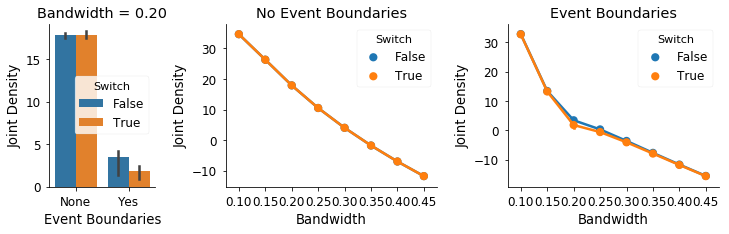

In [162]:
fig, axes = plt.subplots(1, 3, gridspec_kw={'width_ratios':[1, 2, 2], 'wspace':0.4}, figsize=(12, 3))

h = 0.2

def log_mean(x):
    return logsumexp(x, axis=0) - np.log(np.shape(x)[0])

df = pd.concat([
    pd.DataFrame({
        'Event Boundaries': ["None"] * n_batches,
        'Switch': [False] * n_batches,
        'Score': joint_no_bound_pre[:, idx],
    }), pd.DataFrame({
        'Event Boundaries': ["None"] * n_batches,
        'Switch': [True] * n_batches,
        'Score': joint_no_bound_pst[:, idx]
    }), pd.DataFrame({
        'Event Boundaries': ["Yes"] * n_batches,
        'Switch': [False] * n_batches,
        'Score': joint_known_bound_pre[:, idx]
    }), pd.DataFrame({
        'Event Boundaries': ['Yes'] * n_batches,
        'Switch': [True] * n_batches,
        'Score': joint_known_bound_pst[:, idx]
    })
    
])


sns.barplot(data=df, x='Event Boundaries', y='Score', hue='Switch', estimator=log_mean, ax=axes[0])
axes[0].set_ylabel(r'Joint Density')
axes[0].set_title('Bandwidth = %0.2f' % h)


df = []
for ii, h in enumerate(hs):
    df.append(pd.DataFrame({
        'Switch': [False] * n_batches,
        'Bandwidth': [h] * n_batches,
        'Joint Density': joint_no_bound_pst[:, ii]
    }))
    df.append(pd.DataFrame({
        'Switch': [True] * n_batches,
        'Bandwidth': [h] * n_batches,
        'Joint Density': joint_no_bound_pst[:, ii]
    }))
df = pd.concat(df)

sns.pointplot(x='Bandwidth', y='Joint Density', hue='Switch', 
                   estimator=log_mean, data=df, ax = axes[1])

df = []
for ii, h in enumerate(hs):
    df.append(pd.DataFrame({
        'Switch': [False] * n_batches,
        'Bandwidth': [h] * n_batches,
        'Joint Density': joint_known_bound_pre[:, ii]
    }))
    df.append(pd.DataFrame({
        'Switch': [True] * n_batches,
        'Bandwidth': [h] * n_batches,
        'Joint Density': joint_known_bound_pst[:, ii]
    }))
df = pd.concat(df)

sns.pointplot(x='Bandwidth', y='Joint Density', hue='Switch', 
                   estimator=log_mean, data=df, ax = axes[2])
axes[1].set_xticklabels(['%.2f' % h for h in hs])
axes[2].set_xticklabels(['%.2f' % h for h in hs])

axes[1].set_title('No Event Boundaries')
axes[2].set_title('Event Boundaries')

sns.despine()


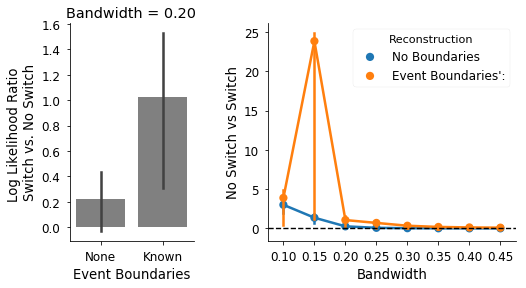

In [163]:
fig, axes = plt.subplots(1, 2, gridspec_kw={'width_ratios':[1, 2], 'wspace':0.4}, figsize=(8, 4))

h = 0.2

df = pd.concat([
    pd.DataFrame({
        'Event Boundaries': ["None"] * n_batches,
        'Score': joint_no_bound_pre[:, idx] - joint_no_bound_pst[:, idx],
    }), pd.DataFrame({
        'Event Boundaries': ["Known"] * n_batches,
        'Score': joint_known_bound_pre[:, idx] - joint_known_bound_pst[:, idx],
    })
])

def log_mean(x):
    return logsumexp(x, axis=0) - np.log(np.shape(x)[0])

sns.barplot(data=df, x='Event Boundaries', y='Score', estimator=log_mean, color=[0.5, 0.5, 0.5], ax=axes[0])
axes[0].set_ylabel(u'Log Likelihood Ratio \nSwitch vs. No Switch')
axes[0].set_title('Bandwidth = %0.2f' % h)


df = []
for ii, h in enumerate(hs):
    df.append(pd.DataFrame({
        'Reconstruction': ["No Boundaries"] * n_batches,
        'Bandwidth': [h] * n_batches,
        'No Switch vs Switch': joint_no_bound_pre[:, ii] - joint_no_bound_pst[:, ii],
    }))
    df.append(pd.DataFrame({
        'Reconstruction': ["Event Boundaries':"] * n_batches,
        'Bandwidth': [h] * n_batches,
        'No Switch vs Switch':joint_known_bound_pre[:, ii] - joint_known_bound_pst[:, ii]
    }))
df = pd.concat(df)

sns.pointplot(x='Bandwidth', y='No Switch vs Switch', hue='Reconstruction', 
                   estimator=log_mean, data=df, ax = axes[1])
axes[1].plot(axes[1].get_xlim(), [0, 0], 'k--')
axes[1].set_xticklabels(['%.2f' % h for h in hs])

sns.despine()
# plt.savefig('Divachi_logLikelihoodRatio.png', dpi=300, bbox_inches='tight')

In [104]:
help(g.set)

Help on method set in module seaborn.axisgrid:

set(self, **kwargs) method of seaborn.axisgrid.FacetGrid instance
    Set attributes on each subplot Axes.



In [ ]:
raise(Exception)